In [146]:
import pandas as pd

In [147]:
def parse_weights_string(weights_str):
    weights_str = weights_str.replace("[", "").replace("]", "").replace("\r\n", "").replace(",", " ").strip()  # Remove unwanted characters
    weights_list = [float(w) for w in weights_str.split()]  # Split and convert elements to float
    return weights_list

In [148]:
# obtain 63-day price movement for each ticker
stock_data = pd.read_csv('SP500_stock_prices.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data[stock_data['Date'] >= '2019-10-01']
stock_data = stock_data[stock_data['Date'] <= '2020-04-02']
stock_data = stock_data[['Date', 'Ticker', 'Close']]
# Make Date the index
stock_data = stock_data.set_index('Date')
# make the index to be the date
stock_data.index = pd.to_datetime(stock_data.index)

# Calculate returns over 63 business days
# select only the ticker index
indiviual_datas = []

for ticker in stock_data['Ticker'].unique():
    #data_ticker = data.xs(0, level=1).copy()
    data_ticker = stock_data[stock_data['Ticker'] == ticker].copy()
    # make target column
    data_ticker['63-day Price Movement'] = data_ticker['Close'].pct_change(63).shift(-63)
    data_ticker.dropna(inplace=True)
    data_ticker

    indiviual_datas.append(data_ticker)

data_all_tickers = pd.concat(indiviual_datas)
data_all_tickers

,Ticker,Close,63-day Price Movement
Date,,,
2019-10-01,MMM,158.380005,0.113903
2019-10-02,MMM,155.649994,0.156441
2019-10-03,MMM,155.229996,0.149584
2019-10-04,MMM,155.820007,0.146323
2019-10-07,MMM,153.520004,0.158807
...,...,...,...
2019-12-24,ZTS,132.919998,-0.112925
2019-12-26,ZTS,133.029999,-0.159814
2019-12-27,ZTS,133.250000,-0.124353


Test 1:

In [149]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_1 = pd.read_csv('LSTM_results_optimal_exp_cycl_1ddh.csv', index_col=0)

# rename the columns
LSTM_results_1.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_1)):
    LSTM_results_1['Optimal Weights'][i] = parse_weights_string(LSTM_results_1['Optimal Weights'][i])

# make the index to be the date
LSTM_results_1.index = pd.to_datetime(LSTM_results_1.index)

optimal_weights_dict_1 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_1.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_1[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_1 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_1.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_1 = stock_returns_1.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_1['Weighted Returns'] = stock_returns_1['Weight'] * stock_returns_1['63-day Price Movement']
# remove all rows with NaN values
stock_returns_1.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_1 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_1.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_1:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_1[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_1[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_1['Actual Returns (%)'] = LSTM_results_1.index.map(portfolio_returns_dict_1)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_1['Actual Returns (%)'] = LSTM_results_1['Actual Returns (%)'] * 100
LSTM_results_1['Estimated Return'] = LSTM_results_1['Estimated Return'] * 100
LSTM_results_1['Estimated Risk'] = LSTM_results_1['Estimated Risk'] * 100
# Rename the columns
LSTM_results_1.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_1

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\2305873208.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_1['Optimal Weights'][i] = parse_weights_string(LSTM_results_1['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'ESS', 'EL', 'HES', 'SBUX', 'NRG', 'B...","[0.58194811, 0.1096926, 0.105634, 0.08097254, ...",10.621858,7.149949,15.055580
2019-10-02,"['WMT', 'LIN', 'REGN', 'TT', 'VRSN', 'EXPD', '...","[0.25187489, 0.12750078, 0.11471352, 0.1040115...",8.368634,6.846830,14.850525
2019-10-03,"['ALLE', 'AJG', 'REGN', 'MA', 'EPAM', 'LKQ', '...","[0.37840509, 0.12704652, 0.12211236, 0.1188712...",13.612005,6.645907,18.700954
2019-10-04,"['ALLE', 'PRU', 'TMO', 'IFF', 'EPAM', 'CCL', '...","[0.45461912, 0.13293513, 0.09813118, 0.0956286...",10.195967,6.314297,13.934358
2019-10-07,"['ALLE', 'IT', 'PXD', 'ETN', 'JNJ', 'GPC', 'AM...","[0.39478636, 0.15579055, 0.14975319, 0.0630107...",9.822290,6.493218,16.744860
...,...,...,...,...,...
2019-12-23,"['GNRC', 'FISV', 'YUM', 'GPN', 'WDC', 'GIS', '...","[0.36261092, 0.2332614, 0.16516553, 0.0533246,...",7.368927,7.394991,-14.657698
2019-12-24,"['GNRC', 'ABT', 'DOV', 'AON', 'HES', 'LDOS', '...","[0.40365114, 0.21076547, 0.11901758, 0.0849406...",7.635499,9.093486,-14.533963
2019-12-26,"['PLD', 'ENPH', 'KLAC', 'NFLX', 'CL', 'CLX', '...","[0.27114468, 0.26590796, 0.11339074, 0.0909970...",9.666525,15.074988,-1.918713


In [150]:
# calculate mean and median of actual returns and print them
mean_actual_returns_1 = LSTM_results_1['Actual Returns (%)'].mean()
median_actual_returns_1 = LSTM_results_1['Actual Returns (%)'].median()
print(f"Mean Actual Returns: {mean_actual_returns_1}")
print(f"Median Actual Returns: {median_actual_returns_1}")

Mean Actual Returns: 7.263288866689443
Median Actual Returns: 13.212649108201363


Test 2:

In [151]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_2 = pd.read_csv('LSTM_results_optimal_exp_cycl_1ddhh.csv', index_col=0)

# rename the columns
LSTM_results_2.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_2)):
    LSTM_results_2['Optimal Weights'][i] = parse_weights_string(LSTM_results_2['Optimal Weights'][i])

# make the index to be the date
LSTM_results_2.index = pd.to_datetime(LSTM_results_2.index)

optimal_weights_dict_2 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_2.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_2[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_2 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_2.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_2 = stock_returns_2.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_2['Weighted Returns'] = stock_returns_2['Weight'] * stock_returns_2['63-day Price Movement']
# remove all rows with NaN values
stock_returns_2.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_2 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_2.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_2:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_2[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_2[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_2['Actual Returns (%)'] = LSTM_results_2.index.map(portfolio_returns_dict_2)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_2['Actual Returns (%)'] = LSTM_results_2['Actual Returns (%)'] * 100
LSTM_results_2['Estimated Return'] = LSTM_results_2['Estimated Return'] * 100
LSTM_results_2['Estimated Risk'] = LSTM_results_2['Estimated Risk'] * 100
# Rename the columns
LSTM_results_2.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_2

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\3319692771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_2['Optimal Weights'][i] = parse_weights_string(LSTM_results_2['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['GRMN', 'CNC', 'HII', 'REGN', 'AWK', 'NFLX', ...","[0.44790664, 0.14171819, 0.131464, 0.09450743,...",12.667078,7.770694,20.239808
2019-10-02,"['ALLE', 'SWK', 'VRSK', 'DUK', 'BDX', 'DRI', '...","[0.54692371, 0.14765443, 0.11179518, 0.0592047...",9.480156,6.762685,17.320830
2019-10-03,"['ALLE', 'WMT', 'MCD', 'FICO', 'SBAC', 'SEDG',...","[0.35168103, 0.20629585, 0.14567715, 0.1380904...",10.858057,6.716143,12.539959
2019-10-04,"['ALLE', 'EPAM', 'J', 'ZBRA', 'MSCI', 'NTAP', ...","[0.38192856, 0.1996291, 0.12191819, 0.06758953...",11.940025,7.300428,16.335335
2019-10-07,"['ALLE', 'PAYC', 'NEE', 'CMCSA', 'BK', 'CL', '...","[0.44771114, 0.13587717, 0.11252307, 0.0982289...",12.502467,8.601837,15.181310
...,...,...,...,...,...
2019-12-23,"['FISV', 'MSCI', 'ROST', 'NFLX', 'SO', 'ZTS', ...","[0.35192268, 0.26805046, 0.13070365, 0.0816209...",6.327561,8.290731,-6.044887
2019-12-24,"['GNRC', 'AFL', 'IQV', 'SO', 'AAPL', 'WST', 'R...","[0.28362538, 0.22004477, 0.14066235, 0.0824969...",6.913391,6.917199,-15.171956
2019-12-26,"['GNRC', 'RMD', 'RVTY', 'TGT', 'LNT', 'LLY', '...","[0.48004078, 0.22933241, 0.07745865, 0.0618696...",7.374141,9.549401,-12.868197


In [152]:
# calculate mean and median of actual returns and print them
mean_actual_returns_2 = LSTM_results_2['Actual Returns (%)'].mean()
median_actual_returns_2 = LSTM_results_2['Actual Returns (%)'].median()
print(f"Test 2: Mean Actual Returns: {mean_actual_returns_2}")
print(f"Test 2: Median Actual Returns: {median_actual_returns_2}")

Test 2: Mean Actual Returns: 6.53069541064053
Test 2: Median Actual Returns: 11.545733433440322


Test 3:

In [153]:
import pandas as pd

# load in the LSTM_results.csv file
LSTM_results_3 = pd.read_csv('LSTM_results_optimal_exp_cycl_1dh.csv', index_col=0)

# rename the columns
LSTM_results_3.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_3)):
    LSTM_results_3['Optimal Weights'][i] = parse_weights_string(LSTM_results_3['Optimal Weights'][i])

# make the index to be the date
LSTM_results_3.index = pd.to_datetime(LSTM_results_3.index)

optimal_weights_dict_3 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_3.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_3[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_3 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_3.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_3 = stock_returns_3.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_3['Weighted Returns'] = stock_returns_3['Weight'] * stock_returns_3['63-day Price Movement']
# remove all rows with NaN values
stock_returns_3.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_3 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_3.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_3:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_3[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_3[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_3['Actual Returns (%)'] = LSTM_results_3.index.map(portfolio_returns_dict_3)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_3['Actual Returns (%)'] = LSTM_results_3['Actual Returns (%)'] * 100
LSTM_results_3['Estimated Return'] = LSTM_results_3['Estimated Return'] * 100
LSTM_results_3['Estimated Risk'] = LSTM_results_3['Estimated Risk'] * 100
# Rename the columns
LSTM_results_3.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_3

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\12573239.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_3['Optimal Weights'][i] = parse_weights_string(LSTM_results_3['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['REGN', 'BMY', 'DIS', 'AJG', 'SEDG', 'ARE', '...","[0.2899432, 0.14746246, 0.13647175, 0.11001044...",11.752547,10.722869,20.111569
2019-10-02,"['REGN', 'TMO', 'INTU', 'EW', 'FIS', 'FISV', '...","[0.22909964, 0.17941917, 0.15231772, 0.1334735...",11.973667,8.614934,15.174498
2019-10-03,"['PFE', 'CNC', 'DRI', 'REGN', 'MNST', 'GL', 'L...","[0.28235481, 0.18926317, 0.12461542, 0.1223240...",10.494033,7.822638,17.405041
2019-10-04,"['ALLE', 'GRMN', 'EXC', 'ORLY', 'CFG', 'SWK', ...","[0.40286559, 0.15063352, 0.12272685, 0.0753593...",9.640692,5.326729,13.182535
2019-10-07,"['ALLE', 'NEE', 'CME', 'MTB', 'GPN', 'WRB', 'C...","[0.2648988, 0.19030157, 0.18750749, 0.17425841...",8.143289,5.062205,7.246885
...,...,...,...,...,...
2019-12-23,"['ETR', 'GRMN', 'VRSN', 'ENPH', 'CDW', 'TDY', ...","[0.21474371, 0.20259831, 0.13473745, 0.1255692...",7.017115,8.595268,-17.066894
2019-12-24,"['GNRC', 'ALL', 'PTC', 'HON', 'MSCI', 'BA', 'M...","[0.41681367, 0.16669302, 0.13634843, 0.1026406...",7.077167,9.143265,-12.830855
2019-12-26,"['BRO', 'ETR', 'EW', 'XOM', 'CNP', 'DUK', 'AON...","[0.57094374, 0.16593001, 0.06380186, 0.0623355...",4.595274,5.900717,-15.365296


In [154]:
# calculate mean and median of actual returns and print them
mean_actual_returns_3 = LSTM_results_3['Actual Returns (%)'].mean()
median_actual_returns_3 = LSTM_results_3['Actual Returns (%)'].median()
print(f"Test 3: Mean Actual Returns: {mean_actual_returns_3}")
print(f"Test 3: Median Actual Returns: {median_actual_returns_3}")

Test 3: Mean Actual Returns: 6.00743961086043
Test 3: Median Actual Returns: 11.031164018011962


Test 4:

In [155]:
# load in the LSTM_results.csv file
LSTM_results_4 = pd.read_csv('LSTM_results_optimal_exp_cycl_1dhh.csv', index_col=0)

# rename the columns
LSTM_results_4.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_4)):
    LSTM_results_4['Optimal Weights'][i] = parse_weights_string(LSTM_results_4['Optimal Weights'][i])

# make the index to be the date
LSTM_results_4.index = pd.to_datetime(LSTM_results_4.index)

optimal_weights_dict_4 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_4.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_4[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_4 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_4.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_4 = stock_returns_4.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_4['Weighted Returns'] = stock_returns_4['Weight'] * stock_returns_4['63-day Price Movement']
# remove all rows with NaN values
stock_returns_4.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_4 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_4.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_4:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_4[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_4[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_4['Actual Returns (%)'] = LSTM_results_4.index.map(portfolio_returns_dict_4)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_4['Actual Returns (%)'] = LSTM_results_4['Actual Returns (%)'] * 100
LSTM_results_4['Estimated Return'] = LSTM_results_4['Estimated Return'] * 100
LSTM_results_4['Estimated Risk'] = LSTM_results_4['Estimated Risk'] * 100
# Rename the columns
LSTM_results_4.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_4

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\4277324586.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_4['Optimal Weights'][i] = parse_weights_string(LSTM_results_4['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'MA', 'K', 'FLT', 'GRMN', 'REGN', 'PN...","[0.39680374, 0.14784348, 0.12327637, 0.1219125...",10.452145,6.510993,16.451730
2019-10-02,"['ALLE', 'ALGN', 'ABC', 'AXP', 'ALB', 'MPC', '...","[0.54674769, 0.11262721, 0.10615922, 0.0888638...",12.462613,7.958483,22.786293
2019-10-03,"['ALLE', 'CNC', 'DHI', 'LIN', 'HIG', 'ANSS', '...","[0.36777124, 0.23366438, 0.10428355, 0.0995414...",14.184348,7.610000,20.592295
2019-10-04,"['REGN', 'ALLE', 'ARE', 'HCA', 'GILD', 'GOOG',...","[0.28496271, 0.27082016, 0.11905695, 0.1145954...",15.614800,9.327258,19.815748
2019-10-07,"['GRMN', 'REGN', 'BRO', 'KMB', 'CNP', 'BXP', '...","[0.2302299, 0.21615452, 0.20464071, 0.14207582...",10.966417,7.325634,12.158251
...,...,...,...,...,...
2019-12-23,"['GNRC', 'MKTX', 'CINF', 'DG', 'NEE', 'LMT', '...","[0.33851819, 0.23978735, 0.09933631, 0.0914610...",8.520223,7.701368,-14.876695
2019-12-24,"['GNRC', 'ICE', 'HON', 'LDOS', 'PEP', 'LIN', '...","[0.34638567, 0.14750078, 0.1463377, 0.09900911...",6.848840,7.432066,-12.398941
2019-12-26,"['GNRC', 'AXP', 'DHR', 'RMD', 'AWK', 'HRL', 'M...","[0.26939556, 0.17457748, 0.13089021, 0.1278612...",5.562375,7.549174,-14.582016


In [156]:
# calculate mean and median of actual returns and print them
mean_actual_returns_4 = LSTM_results_4['Actual Returns (%)'].mean()
median_actual_returns_4 = LSTM_results_4['Actual Returns (%)'].median()
print(f"Test 4: Mean Actual Returns: {mean_actual_returns_4}")
print(f"Test 4: Median Actual Returns: {median_actual_returns_4}")

Test 4: Mean Actual Returns: 5.8531165563226635
Test 4: Median Actual Returns: 10.54135097344237


Test 5:

In [157]:
# load in the LSTM_results.csv file
LSTM_results_5 = pd.read_csv('LSTM_results_optimal_exp_cycl_2ddh.csv', index_col=0)

# rename the columns
LSTM_results_5.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_5)):
    LSTM_results_5['Optimal Weights'][i] = parse_weights_string(LSTM_results_5['Optimal Weights'][i])

# make the index to be the date
LSTM_results_5.index = pd.to_datetime(LSTM_results_5.index)

optimal_weights_dict_5 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_5.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_5[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_5 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_5.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_5 = stock_returns_5.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_5['Weighted Returns'] = stock_returns_5['Weight'] * stock_returns_5['63-day Price Movement']
# remove all rows with NaN values
stock_returns_5.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_5 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_5.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_5:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_5[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_5[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_5['Actual Returns (%)'] = LSTM_results_5.index.map(portfolio_returns_dict_5)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_5['Actual Returns (%)'] = LSTM_results_5['Actual Returns (%)'] * 100
LSTM_results_5['Estimated Return'] = LSTM_results_5['Estimated Return'] * 100
LSTM_results_5['Estimated Risk'] = LSTM_results_5['Estimated Risk'] * 100
# Rename the columns
LSTM_results_5.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']
LSTM_results_5

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\2003831267.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_5['Optimal Weights'][i] = parse_weights_string(LSTM_results_5['Optimal Weights'][i])


,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-10-01,"['ALLE', 'AON', 'MSCI', 'APH', 'NVDA', 'BIIB',...","[0.35176973, 0.30894448, 0.15533865, 0.0766317...",8.847907,6.592089,17.777975
2019-10-02,"['ALLE', 'CNC', 'GL', 'MSFT', 'MHK', 'URI', 'A...","[0.3874011, 0.20819356, 0.15020256, 0.11045013...",12.093823,7.469648,25.457223
2019-10-03,"['ALLE', 'AVY', 'CPT', 'TDG', 'ADI', 'AIG', 'L...","[0.48256829, 0.1592476, 0.1145573, 0.099774, 0...",10.143090,6.692237,15.400835
2019-10-04,"['ALLE', 'O', 'FDX', 'APH', 'LHX', 'LH', 'EQR'...","[0.53637534, 0.18453836, 0.12228713, 0.0345872...",10.340700,6.958305,10.685551
2019-10-07,"['REGN', 'FAST', 'MKTX', 'GPN', 'INTU', 'STZ',...","[0.26311716, 0.17850633, 0.12688172, 0.1227030...",11.238640,9.059289,14.050246
...,...,...,...,...,...
2019-12-23,"['BRO', 'COST', 'HD', 'GNRC', 'BR', 'LNT', 'AE...","[0.22152911, 0.19211686, 0.12507188, 0.1137650...",4.681579,5.932886,-16.890514
2019-12-24,"['GNRC', 'AWK', 'AXP', 'XOM', 'AME', 'FITB', '...","[0.42500464, 0.30172664, 0.14487565, 0.0510374...",8.651704,9.355909,-10.424020
2019-12-26,"['ENPH', 'DRI', 'LNT', 'SJM', 'DHR', 'PGR', 'U...","[0.25882322, 0.22373804, 0.13050159, 0.1154328...",9.281038,14.083769,-10.196735


In [158]:
# calculate mean and median of actual returns and print them
mean_actual_returns_5 = LSTM_results_5['Actual Returns (%)'].mean()
median_actual_returns_5 = LSTM_results_5['Actual Returns (%)'].median()
print(f"Test 5: Mean Actual Returns: {mean_actual_returns_5}")
print(f"Test 5: Median Actual Returns: {median_actual_returns_5}")

Test 5: Mean Actual Returns: 7.023298069330164
Test 5: Median Actual Returns: 11.628849759216173


Test 6:

In [159]:
# load in the LSTM_results.csv file
LSTM_results_6 = pd.read_csv('LSTM_results_optimal_exp_cycl_2ddhh.csv', index_col=0)

# rename the columns
LSTM_results_6.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_6)):
    LSTM_results_6['Optimal Weights'][i] = parse_weights_string(LSTM_results_6['Optimal Weights'][i])

# make the index to be the date
LSTM_results_6.index = pd.to_datetime(LSTM_results_6.index)

optimal_weights_dict_6 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_6.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_6[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_6 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_6.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_6 = stock_returns_6.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_6['Weighted Returns'] = stock_returns_6['Weight'] * stock_returns_6['63-day Price Movement']
# remove all rows with NaN values
stock_returns_6.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_6 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_6.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_6:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_6[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_6[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_6['Actual Returns (%)'] = LSTM_results_6.index.map(portfolio_returns_dict_6)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_6['Actual Returns (%)'] = LSTM_results_6['Actual Returns (%)'] * 100
LSTM_results_6['Estimated Return'] = LSTM_results_6['Estimated Return'] * 100
LSTM_results_6['Estimated Risk'] = LSTM_results_6['Estimated Risk'] * 100
# Rename the columns
LSTM_results_6.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\1972489593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_6['Optimal Weights'][i] = parse_weights_string(LSTM_results_6['Optimal Weights'][i])


In [160]:
# calculate mean and median of actual returns and print them
mean_actual_returns_6 = LSTM_results_6['Actual Returns (%)'].mean()
median_actual_returns_6 = LSTM_results_6['Actual Returns (%)'].median()
print(f"Test 6: Mean Actual Returns: {mean_actual_returns_6}")
print(f"Test 6: Median Actual Returns: {median_actual_returns_6}")

Test 6: Mean Actual Returns: 7.36416162238122
Test 6: Median Actual Returns: 13.090503469116213


Test 7:

In [161]:
# load in the LSTM_results.csv file
LSTM_results_7 = pd.read_csv('LSTM_results_optimal_exp_cycl_2dh.csv', index_col=0)

# rename the columns
LSTM_results_7.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_7)):
    LSTM_results_7['Optimal Weights'][i] = parse_weights_string(LSTM_results_7['Optimal Weights'][i])

# make the index to be the date
LSTM_results_7.index = pd.to_datetime(LSTM_results_7.index)

optimal_weights_dict_7 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_7.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_7[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_7 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_7.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_7 = stock_returns_7.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_7['Weighted Returns'] = stock_returns_7['Weight'] * stock_returns_7['63-day Price Movement']
# remove all rows with NaN values
stock_returns_7.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_7 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_7.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_7:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_7[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_7[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_7['Actual Returns (%)'] = LSTM_results_7.index.map(portfolio_returns_dict_7)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_7['Actual Returns (%)'] = LSTM_results_7['Actual Returns (%)'] * 100
LSTM_results_7['Estimated Return'] = LSTM_results_7['Estimated Return'] * 100
LSTM_results_7['Estimated Risk'] = LSTM_results_7['Estimated Risk'] * 100
# Rename the columns
LSTM_results_7.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\2310747336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_7['Optimal Weights'][i] = parse_weights_string(LSTM_results_7['Optimal Weights'][i])


In [162]:
# calculate mean and median of actual returns and print them
mean_actual_returns_7 = LSTM_results_7['Actual Returns (%)'].mean()
median_actual_returns_7 = LSTM_results_7['Actual Returns (%)'].median()
print(f"Test 7: Mean Actual Returns: {mean_actual_returns_7}")
print(f"Test 7: Median Actual Returns: {median_actual_returns_7}")

Test 7: Mean Actual Returns: 7.105193461391601
Test 7: Median Actual Returns: 13.09609473159901


Test 8:

In [163]:
# load in the LSTM_results.csv file
LSTM_results_8 = pd.read_csv('LSTM_results_optimal_exp_cycl_2dhh.csv', index_col=0)

# rename the columns
LSTM_results_8.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_8)):
    LSTM_results_8['Optimal Weights'][i] = parse_weights_string(LSTM_results_8['Optimal Weights'][i])

# make the index to be the date
LSTM_results_8.index = pd.to_datetime(LSTM_results_8.index)

optimal_weights_dict_8 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_8.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_8[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_8 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_8.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_8 = stock_returns_8.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_8['Weighted Returns'] = stock_returns_8['Weight'] * stock_returns_8['63-day Price Movement']
# remove all rows with NaN values
stock_returns_8.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_8 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_8.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_8:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_8[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_8[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_8['Actual Returns (%)'] = LSTM_results_8.index.map(portfolio_returns_dict_8)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_8['Actual Returns (%)'] = LSTM_results_8['Actual Returns (%)'] * 100
LSTM_results_8['Estimated Return'] = LSTM_results_8['Estimated Return'] * 100
LSTM_results_8['Estimated Risk'] = LSTM_results_8['Estimated Risk'] * 100
# Rename the columns
LSTM_results_8.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\3477971606.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_8['Optimal Weights'][i] = parse_weights_string(LSTM_results_8['Optimal Weights'][i])


In [164]:
# calculate mean and median of actual returns and print them
mean_actual_returns_8 = LSTM_results_8['Actual Returns (%)'].mean()
median_actual_returns_8 = LSTM_results_8['Actual Returns (%)'].median()
print(f"Test 8: Mean Actual Returns: {mean_actual_returns_8}")
print(f"Test 8: Median Actual Returns: {median_actual_returns_8}")

Test 8: Mean Actual Returns: 7.838965236274426
Test 8: Median Actual Returns: 11.19896996966325


Test 9:

In [165]:
# load in the LSTM_results.csv file
LSTM_results_9 = pd.read_csv('LSTM_results_optimal_exp_plat_1ddh.csv', index_col=0)

# rename the columns
LSTM_results_9.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_9)):
    LSTM_results_9['Optimal Weights'][i] = parse_weights_string(LSTM_results_9['Optimal Weights'][i])

# make the index to be the date
LSTM_results_9.index = pd.to_datetime(LSTM_results_9.index)

optimal_weights_dict_9 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_9.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_9[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_9 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_9.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_9 = stock_returns_9.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_9['Weighted Returns'] = stock_returns_9['Weight'] * stock_returns_9['63-day Price Movement']
# remove all rows with NaN values
stock_returns_9.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_9 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_9.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_9:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_9[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_9[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_9['Actual Returns (%)'] = LSTM_results_9.index.map(portfolio_returns_dict_9)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_9['Actual Returns (%)'] = LSTM_results_9['Actual Returns (%)'] * 100
LSTM_results_9['Estimated Return'] = LSTM_results_9['Estimated Return'] * 100
LSTM_results_9['Estimated Risk'] = LSTM_results_9['Estimated Risk'] * 100
# Rename the columns
LSTM_results_9.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\1820644339.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_9['Optimal Weights'][i] = parse_weights_string(LSTM_results_9['Optimal Weights'][i])


In [166]:
# calculate mean and median of actual returns and print them
mean_actual_returns_9 = LSTM_results_9['Actual Returns (%)'].mean()
median_actual_returns_9 = LSTM_results_9['Actual Returns (%)'].median()
print(f"Test 9: Mean Actual Returns: {mean_actual_returns_9}")
print(f"Test 9: Median Actual Returns: {median_actual_returns_9}")

Test 9: Mean Actual Returns: 5.851005655403382
Test 9: Median Actual Returns: 11.161705313161718


Test 10:

In [167]:
# load in the LSTM_results.csv file
LSTM_results_10 = pd.read_csv('LSTM_results_optimal_exp_plat_1ddhh.csv', index_col=0)

# rename the columns
LSTM_results_10.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_10)):
    LSTM_results_10['Optimal Weights'][i] = parse_weights_string(LSTM_results_10['Optimal Weights'][i])

# make the index to be the date
LSTM_results_10.index = pd.to_datetime(LSTM_results_10.index)

optimal_weights_dict_10 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_10.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_10[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_10 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_10.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_10 = stock_returns_10.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_10['Weighted Returns'] = stock_returns_10['Weight'] * stock_returns_10['63-day Price Movement']
# remove all rows with NaN values
stock_returns_10.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_10 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_10.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_10:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_10[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_10[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_10['Actual Returns (%)'] = LSTM_results_10.index.map(portfolio_returns_dict_10)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_10['Actual Returns (%)'] = LSTM_results_10['Actual Returns (%)'] * 100
LSTM_results_10['Estimated Return'] = LSTM_results_10['Estimated Return'] * 100
LSTM_results_10['Estimated Risk'] = LSTM_results_10['Estimated Risk'] * 100
# Rename the columns
LSTM_results_10.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\884160751.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_10['Optimal Weights'][i] = parse_weights_string(LSTM_results_10['Optimal Weights'][i])


In [168]:
# calculate mean and median of actual returns and print them
mean_actual_returns_10 = LSTM_results_10['Actual Returns (%)'].mean()
median_actual_returns_10 = LSTM_results_10['Actual Returns (%)'].median()
print(f"Test_10: Mean Actual Returns: {mean_actual_returns_10}")
print(f"Test_10: Median Actual Returns: {median_actual_returns_10}")

Test_10: Mean Actual Returns: 6.835570267793189
Test_10: Median Actual Returns: 11.893113554544765


Test 11:

In [169]:
# load in the LSTM_results.csv file
LSTM_results_11 = pd.read_csv('LSTM_results_optimal_exp_plat_1dh.csv', index_col=0)

# rename the columns
LSTM_results_11.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_11)):
    LSTM_results_11['Optimal Weights'][i] = parse_weights_string(LSTM_results_11['Optimal Weights'][i])

# make the index to be the date
LSTM_results_11.index = pd.to_datetime(LSTM_results_11.index)

optimal_weights_dict_11 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_11.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_11[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_11 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_11.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_11 = stock_returns_11.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_11['Weighted Returns'] = stock_returns_11['Weight'] * stock_returns_11['63-day Price Movement']
# remove all rows with NaN values
stock_returns_11.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_11 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_11.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_11:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_11[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_11[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_11['Actual Returns (%)'] = LSTM_results_11.index.map(portfolio_returns_dict_11)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_11['Actual Returns (%)'] = LSTM_results_11['Actual Returns (%)'] * 100
LSTM_results_11['Estimated Return'] = LSTM_results_11['Estimated Return'] * 100
LSTM_results_11['Estimated Risk'] = LSTM_results_11['Estimated Risk'] * 100
# Rename the columns
LSTM_results_11.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\2773471895.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_11['Optimal Weights'][i] = parse_weights_string(LSTM_results_11['Optimal Weights'][i])


In [170]:
# calculate mean and median of actual returns and print them
mean_actual_returns_11 = LSTM_results_11['Actual Returns (%)'].mean()
median_actual_returns_11 = LSTM_results_11['Actual Returns (%)'].median()
print(f"Test 11: Mean Actual Returns: {mean_actual_returns_11}")
print(f"Test 11: Median Actual Returns: {median_actual_returns_11}")

Test 11: Mean Actual Returns: 8.10337896447072
Test 11: Median Actual Returns: 12.606141554675037


Test 12:

In [171]:
# load in the LSTM_results.csv file
LSTM_results_12 = pd.read_csv('LSTM_results_optimal_exp_plat_1dhh.csv', index_col=0)

# rename the columns
LSTM_results_12.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_12)):
    LSTM_results_12['Optimal Weights'][i] = parse_weights_string(LSTM_results_12['Optimal Weights'][i])

# make the index to be the date
LSTM_results_12.index = pd.to_datetime(LSTM_results_12.index)

optimal_weights_dict_12 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_12.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_12[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_12 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_12.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_12 = stock_returns_12.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_12['Weighted Returns'] = stock_returns_12['Weight'] * stock_returns_12['63-day Price Movement']
# remove all rows with NaN values
stock_returns_12.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_12 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_12.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_12:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_12[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_12[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_12['Actual Returns (%)'] = LSTM_results_12.index.map(portfolio_returns_dict_12)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_12['Actual Returns (%)'] = LSTM_results_12['Actual Returns (%)'] * 100
LSTM_results_12['Estimated Return'] = LSTM_results_12['Estimated Return'] * 100
LSTM_results_12['Estimated Risk'] = LSTM_results_12['Estimated Risk'] * 100
# Rename the columns
LSTM_results_12.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\403244013.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_12['Optimal Weights'][i] = parse_weights_string(LSTM_results_12['Optimal Weights'][i])


In [172]:
# calculate mean and median of actual returns and print them
mean_actual_returns_12 = LSTM_results_12['Actual Returns (%)'].mean()
median_actual_returns_12 = LSTM_results_12['Actual Returns (%)'].median()
print(f"Test 12: Mean Actual Returns: {mean_actual_returns_12}")
print(f"Test 12: Median Actual Returns: {median_actual_returns_12}")

Test 12: Mean Actual Returns: 7.748236495153295
Test 12: Median Actual Returns: 11.278572541362474


Test 13:

In [173]:
# load in the LSTM_results.csv file
LSTM_results_13 = pd.read_csv('LSTM_results_optimal_exp_plat_2ddh.csv', index_col=0)

# rename the columns
LSTM_results_13.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_13)):
    LSTM_results_13['Optimal Weights'][i] = parse_weights_string(LSTM_results_13['Optimal Weights'][i])

# make the index to be the date
LSTM_results_13.index = pd.to_datetime(LSTM_results_13.index)

optimal_weights_dict_13 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_13.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_13[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_13 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_13.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_13 = stock_returns_13.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_13['Weighted Returns'] = stock_returns_13['Weight'] * stock_returns_13['63-day Price Movement']
# remove all rows with NaN values
stock_returns_13.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_13 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_13.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_13:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_13[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_13[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_13['Actual Returns (%)'] = LSTM_results_13.index.map(portfolio_returns_dict_13)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_13['Actual Returns (%)'] = LSTM_results_13['Actual Returns (%)'] * 100
LSTM_results_13['Estimated Return'] = LSTM_results_13['Estimated Return'] * 100
LSTM_results_13['Estimated Risk'] = LSTM_results_13['Estimated Risk'] * 100
# Rename the columns
LSTM_results_13.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\2378417707.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_13['Optimal Weights'][i] = parse_weights_string(LSTM_results_13['Optimal Weights'][i])


In [174]:
# calculate mean and median of actual returns and print them
mean_actual_returns_13 = LSTM_results_13['Actual Returns (%)'].mean()
median_actual_returns_13 = LSTM_results_13['Actual Returns (%)'].median()
print(f"Test 13: Mean Actual Returns: {mean_actual_returns_13}")
print(f"Test 13: Median Actual Returns: {median_actual_returns_13}")

Test 13: Mean Actual Returns: 7.003682147374715
Test 13: Median Actual Returns: 11.504741887489873


Test 14:

In [175]:
# load in the LSTM_results.csv file
LSTM_results_14 = pd.read_csv('LSTM_results_optimal_exp_plat_2ddhh.csv', index_col=0)

# rename the columns
LSTM_results_14.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_14)):
    LSTM_results_14['Optimal Weights'][i] = parse_weights_string(LSTM_results_14['Optimal Weights'][i])

# make the index to be the date
LSTM_results_14.index = pd.to_datetime(LSTM_results_14.index)

optimal_weights_dict_14 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_14.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_14[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_14 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_14.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_14 = stock_returns_14.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_14['Weighted Returns'] = stock_returns_14['Weight'] * stock_returns_14['63-day Price Movement']
# remove all rows with NaN values
stock_returns_14.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_14 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_14.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_14:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_14[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_14[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_14['Actual Returns (%)'] = LSTM_results_14.index.map(portfolio_returns_dict_14)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_14['Actual Returns (%)'] = LSTM_results_14['Actual Returns (%)'] * 100
LSTM_results_14['Estimated Return'] = LSTM_results_14['Estimated Return'] * 100
LSTM_results_14['Estimated Risk'] = LSTM_results_14['Estimated Risk'] * 100
# Rename the columns
LSTM_results_14.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\847542166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_14['Optimal Weights'][i] = parse_weights_string(LSTM_results_14['Optimal Weights'][i])


In [176]:
# calculate mean and median of actual returns and print them
mean_actual_returns_14 = LSTM_results_14['Actual Returns (%)'].mean()
median_actual_returns_14 = LSTM_results_14['Actual Returns (%)'].median()
print(f"Test 14: Mean Actual Returns: {mean_actual_returns_14}")
print(f"Test 14: Median Actual Returns: {median_actual_returns_14}")

Test 14: Mean Actual Returns: 6.942875838013439
Test 14: Median Actual Returns: 12.75227169415642


Test 15:

In [177]:
# load in the LSTM_results.csv file
LSTM_results_15 = pd.read_csv('LSTM_results_optimal_exp_plat_2dh.csv', index_col=0)

# rename the columns
LSTM_results_15.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_15)):
    LSTM_results_15['Optimal Weights'][i] = parse_weights_string(LSTM_results_15['Optimal Weights'][i])

# make the index to be the date
LSTM_results_15.index = pd.to_datetime(LSTM_results_15.index)

optimal_weights_dict_15 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_15.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_15[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_15 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_15.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_15 = stock_returns_15.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_15['Weighted Returns'] = stock_returns_15['Weight'] * stock_returns_15['63-day Price Movement']
# remove all rows with NaN values
stock_returns_15.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_15 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_15.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_15:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_15[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_15[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_15['Actual Returns (%)'] = LSTM_results_15.index.map(portfolio_returns_dict_15)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_15['Actual Returns (%)'] = LSTM_results_15['Actual Returns (%)'] * 100
LSTM_results_15['Estimated Return'] = LSTM_results_15['Estimated Return'] * 100
LSTM_results_15['Estimated Risk'] = LSTM_results_15['Estimated Risk'] * 100
# Rename the columns
LSTM_results_15.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\3804596973.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_15['Optimal Weights'][i] = parse_weights_string(LSTM_results_15['Optimal Weights'][i])


In [178]:
# calculate mean and median of actual returns and print them
mean_actual_returns_15 = LSTM_results_15['Actual Returns (%)'].mean()
median_actual_returns_15 = LSTM_results_15['Actual Returns (%)'].median()
print(f"Test 15: Mean Actual Returns: {mean_actual_returns_15}")
print(f"Test 15: Median Actual Returns: {median_actual_returns_15}")

Test 15: Mean Actual Returns: 6.565718378159096
Test 15: Median Actual Returns: 9.633301265893662


Test 16:

In [179]:
# load in the LSTM_results.csv file
LSTM_results_16 = pd.read_csv('LSTM_results_optimal_exp_plat_2dhh.csv', index_col=0)

# rename the columns
LSTM_results_16.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return', 'Estimated Risk']

# for each day in the LSTM_results dataframe, parse the weights string and add it to the dataframe
for i in range(len(LSTM_results_16)):
    LSTM_results_16['Optimal Weights'][i] = parse_weights_string(LSTM_results_16['Optimal Weights'][i])

# make the index to be the date
LSTM_results_16.index = pd.to_datetime(LSTM_results_16.index)

optimal_weights_dict_16 = {}

# Iterate over each row in LSTM_results
for date, row in LSTM_results_16.iterrows():
    # Extract the optimal tickers and their corresponding weights
    tickers = eval(row['Optimal Tickers'])
    weights = row['Optimal Weights']
    
    # Check if the length of tickers matches the length of weights
    if len(tickers) != len(weights):
        print(f"Error: Length of tickers ({len(tickers)}) does not match the length of weights ({len(weights)})")
        continue
    
    # Create a dictionary entry with tickers as keys and weights as values
    optimal_weights_dict_16[date] = dict(zip(tickers, weights))

    # use the optimal_weights_dict to extract the 63-day Price Movement for each ticker on each day
# create a new df called stock_returns
stock_returns_16 = pd.DataFrame()

# iterate over each date in optimal_weights_dict
for date, weights in optimal_weights_dict_16.items():
    # extract the 63-day Price Movement for each ticker on that day
    date_returns = data_all_tickers.loc[date].copy()
    # add the weights to the dataframe
    date_returns['Weight'] = date_returns['Ticker'].map(weights)
    # append the date_returns dataframe to stock_returns
    stock_returns_16 = stock_returns_16.append(date_returns)

# Make a new column called 'Weighted Returns'
stock_returns_16['Weighted Returns'] = stock_returns_16['Weight'] * stock_returns_16['63-day Price Movement']
# remove all rows with NaN values
stock_returns_16.dropna(inplace=True)

# make a new dictionary called portfolio_returns_dict to store the portfolio returns for each day
portfolio_returns_dict_16 = {}

# Iterate over each row in stock_returns
for date, row in stock_returns_16.iterrows():
    # Extract the weighted returns
    weighted_returns = row['Weighted Returns']
    
    # Check if the date already exists in the dictionary
    if date in portfolio_returns_dict_16:
        # If it does, add the weighted returns to the existing value
        portfolio_returns_dict_16[date] += weighted_returns
    else:
        # If it doesn't, set the weighted returns as the value
        portfolio_returns_dict_16[date] = weighted_returns

# make a new column in LSTM_results called 'Actual Returns'
LSTM_results_16['Actual Returns (%)'] = LSTM_results_16.index.map(portfolio_returns_dict_16)

# multiply the 'Actual Returns', Estimated Return and Estimated Risk columns by 100
LSTM_results_16['Actual Returns (%)'] = LSTM_results_16['Actual Returns (%)'] * 100
LSTM_results_16['Estimated Return'] = LSTM_results_16['Estimated Return'] * 100
LSTM_results_16['Estimated Risk'] = LSTM_results_16['Estimated Risk'] * 100
# Rename the columns
LSTM_results_16.columns = ['Optimal Tickers', 'Optimal Weights', 'Estimated Return (%)', 'Estimated Risk', 'Actual Returns (%)']

C:\Users\nicol\AppData\Local\Temp\ipykernel_25544\1566008509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LSTM_results_16['Optimal Weights'][i] = parse_weights_string(LSTM_results_16['Optimal Weights'][i])


In [180]:
# calculate mean and median of actual returns and print them
mean_actual_returns_16 = LSTM_results_16['Actual Returns (%)'].mean()
median_actual_returns_16 = LSTM_results_16['Actual Returns (%)'].median()
print(f"Test 16: Mean Actual Returns: {mean_actual_returns_16}")
print(f"Test 16: Median Actual Returns: {median_actual_returns_16}")

Test 16: Mean Actual Returns: 7.732507284184138
Test 16: Median Actual Returns: 13.165040550421386


In [181]:
# Find the highest mean and median actual returns and print them with their corresponding test number
highest_mean_actual_returns = max(mean_actual_returns_1, mean_actual_returns_2, mean_actual_returns_3, mean_actual_returns_4, mean_actual_returns_5, mean_actual_returns_6, mean_actual_returns_7, mean_actual_returns_8, mean_actual_returns_9, mean_actual_returns_10, mean_actual_returns_11, mean_actual_returns_12, mean_actual_returns_13, mean_actual_returns_14, mean_actual_returns_15)
highest_median_actual_returns = max(median_actual_returns_1, median_actual_returns_2, median_actual_returns_3, median_actual_returns_4, median_actual_returns_5, median_actual_returns_6, median_actual_returns_7, median_actual_returns_8, median_actual_returns_9, median_actual_returns_10, median_actual_returns_11, median_actual_returns_12, median_actual_returns_13, median_actual_returns_14, median_actual_returns_15)

# find the test number of the highest mean and median actual returns
if highest_mean_actual_returns == mean_actual_returns_1:
    print(f"Test 1 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_2:
    print(f"Test 2 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_3:
    print(f"Test 3 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_4:
    print(f"Test 4 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_5:
    print(f"Test 5 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_6:
    print(f"Test 6 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_7:
    print(f"Test 7 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_8:
    print(f"Test 8 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_9:
    print(f"Test 9 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_10:
    print(f"Test 10 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_11:
    print(f"Test 11 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_12:
    print(f"Test 12 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_13:
    print(f"Test 13 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_14:
    print(f"Test 14 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_15:
    print(f"Test 15 had the highest mean actual returns: {highest_mean_actual_returns}")
elif highest_mean_actual_returns == mean_actual_returns_16:
    print(f"Test 16 had the highest mean actual returns: {highest_mean_actual_returns}")






Test 11 had the highest mean actual returns: 8.10337896447072


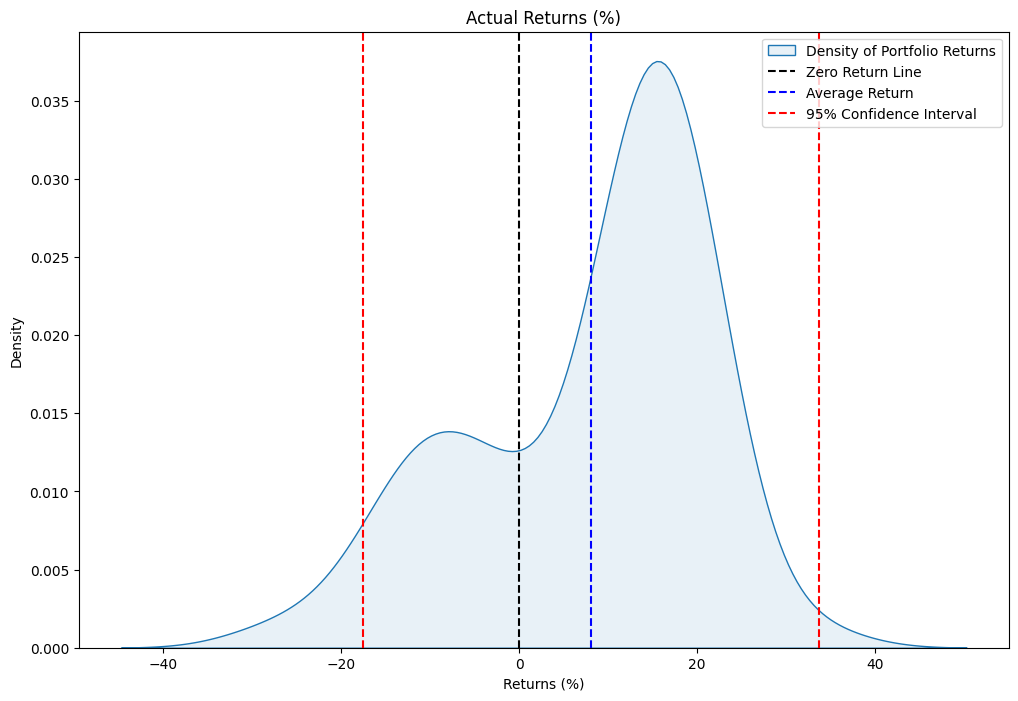

In [182]:
# make density plot of the returns of the test 10 portfolio
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,8), facecolor='white', dpi=100)
sns.kdeplot(data=LSTM_results_11, x='Actual Returns (%)', fill=True, alpha=0.1)
# make 0 vertical line
plt.axvline(x=0, color='black', linestyle='--')
# make average return vertical line
plt.axvline(x=LSTM_results_11['Actual Returns (%)'].mean(), color='blue', linestyle='--')
# include confindence interval vertical lines
plt.axvline(x=LSTM_results_11['Actual Returns (%)'].mean() + 1.96 * LSTM_results_11['Actual Returns (%)'].std(), color='r', linestyle='--')
plt.axvline(x=LSTM_results_11['Actual Returns (%)'].mean() - 1.96 * LSTM_results_11['Actual Returns (%)'].std(), color='r', linestyle='--')
plt.legend(['Density of Portfolio Returns','Zero Return Line', 'Average Return', '95% Confidence Interval'], loc='upper right')
plt.title('Actual Returns (%)')
plt.ylabel('Density')
plt.xlabel('Returns (%)')
plt.show()

In [185]:
lowest_return_11 = LSTM_results_11['Actual Returns (%)'].min()
highest_return_11 = LSTM_results_11['Actual Returns (%)'].max()

lowest_return_date_11 = LSTM_results_11[LSTM_results_11['Actual Returns (%)'] == lowest_return_11].index[0]
highest_return_date_11 = LSTM_results_11[LSTM_results_11['Actual Returns (%)'] == highest_return_11].index[0]

print(f"Test 11 Lowest Return: {lowest_return_11} on date: {lowest_return_date_11}")
print(f"Test 11 Highest Return: {highest_return_11} on date: {highest_return_date_11}")


Test 11 Lowest Return: -27.639486550096994 on date: 2019-12-19 00:00:00
Test 11 Highest Return: 33.177509518603124 on date: 2019-11-27 00:00:00


In [188]:
# print the 10 highest returns
LSTM_results_11.sort_values(by=['Actual Returns (%)'], ascending=False).head(10)

,Optimal Tickers,Optimal Weights,Estimated Return (%),Estimated Risk,Actual Returns (%)
Date,,,,,
2019-11-27,"['GNRC', 'ENPH', 'EXPE', 'NFLX', 'C', 'MPWR', ...","[0.59904742, 0.22265139, 0.0557454, 0.04523045...",14.204567,15.548720,33.177510
2019-10-16,"['TMO', 'BRO', 'UNH', 'SWKS', 'ZBRA', 'TYL', '...","[0.34584315, 0.19443143, 0.17427751, 0.1397696...",10.219546,6.481229,23.224056
2019-10-17,"['ALLE', 'KLAC', 'CNC', 'ELV', 'WYNN', 'STLD',...","[0.25125864, 0.17523259, 0.15625883, 0.1496151...",10.686408,8.546763,23.107098
2019-11-07,"['FICO', 'BRO', 'BMY', 'ABT', 'HSY', 'HCA', 'N...","[0.52058888, 0.18656089, 0.13566335, 0.0459706...",13.358823,11.215819,22.753392
2019-10-25,"['FICO', 'EXC', 'VRSK', 'MOH', 'ALGN', 'EXPD',...","[0.45439098, 0.15197727, 0.14080231, 0.1002967...",14.168780,10.767765,20.847794
2019-10-21,"['ALLE', 'LLY', 'IBM', 'LNC', 'AAPL', 'ECL', '...","[0.49837884, 0.18083239, 0.08856831, 0.0820583...",9.384077,7.206186,20.687769
2019-10-01,"['ALLE', 'WBD', 'GNRC', 'TTWO', 'LDOS', 'DXCM'...","[0.36261707, 0.23065443, 0.1231884, 0.06643615...",9.660144,7.526018,20.622943
2019-11-05,"['FICO', 'CI', 'CNC', 'SO', 'NTRS', 'HAS', 'NF...","[0.50296819, 0.17106804, 0.1001773, 0.05790373...",14.217988,10.793294,19.956413
2019-10-07,"['ALLE', 'REGN', 'AMD', 'VTR', 'AFL', 'STX', '...","[0.51289064, 0.14837939, 0.0797153, 0.0729335,...",14.351331,7.977626,19.743274


In [186]:
# save the results to a csv
LSTM_results_11.to_csv('LSTM_results_optimal.csv')

In [195]:
# Make a dataframe consisting of all the average returns and standard deviations of the 16 tests
average_returns = [LSTM_results_1['Actual Returns (%)'].mean(), LSTM_results_2['Actual Returns (%)'].mean(), LSTM_results_3['Actual Returns (%)'].mean(), LSTM_results_4['Actual Returns (%)'].mean(), LSTM_results_5['Actual Returns (%)'].mean(), LSTM_results_6['Actual Returns (%)'].mean(), LSTM_results_7['Actual Returns (%)'].mean(), LSTM_results_8['Actual Returns (%)'].mean(), LSTM_results_9['Actual Returns (%)'].mean(), LSTM_results_10['Actual Returns (%)'].mean(), LSTM_results_11['Actual Returns (%)'].mean(), LSTM_results_12['Actual Returns (%)'].mean(), LSTM_results_13['Actual Returns (%)'].mean(), LSTM_results_14['Actual Returns (%)'].mean(), LSTM_results_15['Actual Returns (%)'].mean(), LSTM_results_16['Actual Returns (%)'].mean()]
# Make a dataframe consisting of all the average expected returns and standard deviations of the 16 tests
average_expected_returns = [LSTM_results_1['Estimated Return (%)'].mean(), LSTM_results_2['Estimated Return (%)'].mean(), LSTM_results_3['Estimated Return (%)'].mean(), LSTM_results_4['Estimated Return (%)'].mean(), LSTM_results_5['Estimated Return (%)'].mean(), LSTM_results_6['Estimated Return (%)'].mean(), LSTM_results_7['Estimated Return (%)'].mean(), LSTM_results_8['Estimated Return (%)'].mean(), LSTM_results_9['Estimated Return (%)'].mean(), LSTM_results_10['Estimated Return (%)'].mean(), LSTM_results_11['Estimated Return (%)'].mean(), LSTM_results_12['Estimated Return (%)'].mean(), LSTM_results_13['Estimated Return (%)'].mean(), LSTM_results_14['Estimated Return (%)'].mean(), LSTM_results_15['Estimated Return (%)'].mean(), LSTM_results_16['Estimated Return (%)'].mean()]

index = ['cycl_1DH', 'cycl_1Dh', 'cycl_1dH', 'cycl_1dh', 'cycl_2DH', 'cycl_2Dh',
       'cycl_2dH', 'cycl_2dh', 'plat_1DH', 'plat_1Dh', 'plat_1dH', 'plat_1dh',
       'plat_2DH', 'plat_2Dh', 'plat_2dH', 'plat_2dh']
# make a dictionary for each index point  of the average returns and average expected returns together in one
average_returns_expected_returns = {'Average Returns (%)': average_returns, 'Average Expected Returns (%)': average_expected_returns}

# make a dataframe of the average returns and average expected returns
average_returns_expected_returns_df = pd.DataFrame(average_returns_expected_returns, index=index)




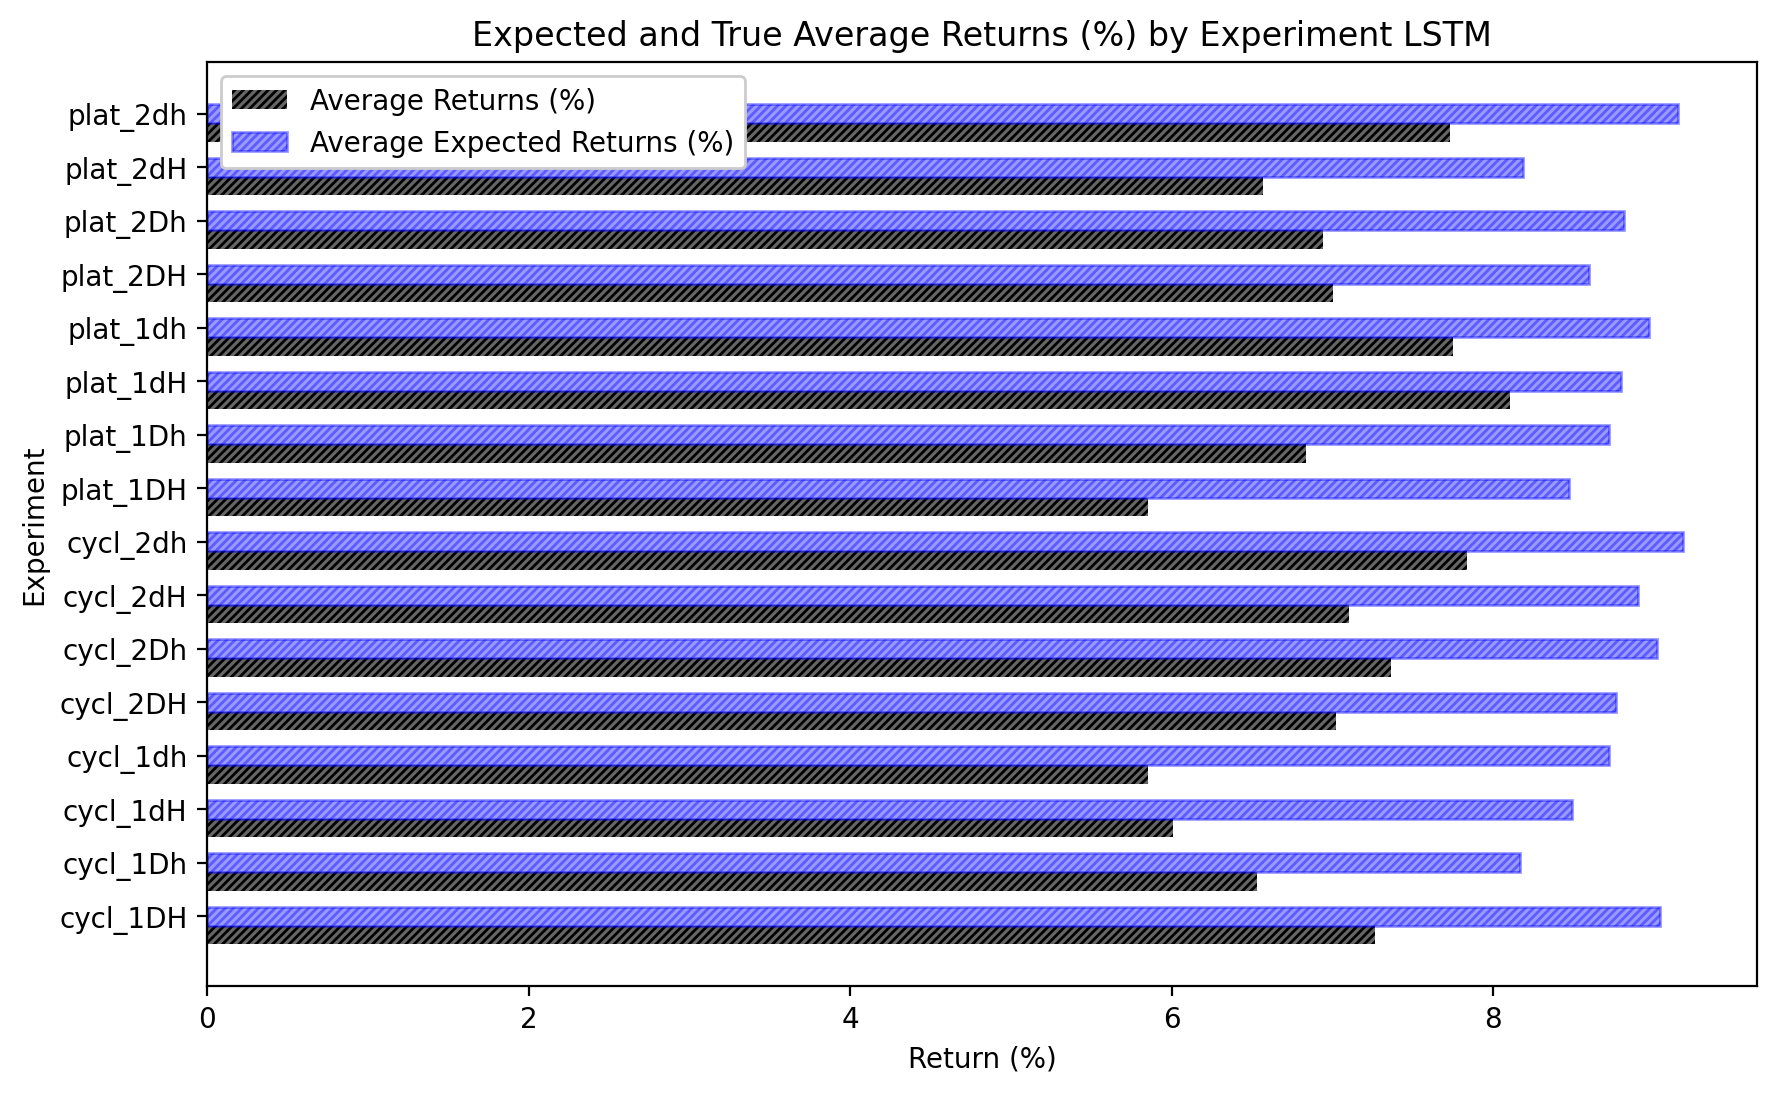

In [221]:
import numpy as np
plt.figure(figsize=(10, 6), dpi=200)

#Create an array with the position of each bar along the x-axis
barWidth = 0.35
r1 = np.arange(len(average_returns_expected_returns_df['Average Returns (%)']))
r2 = [x + barWidth for x in r1]

#Plot 'train_loss'
plt.barh(r1, average_returns_expected_returns_df['Average Returns (%)'], color='black', height=barWidth, label='Average Returns (%)', alpha=0.6,hatch='////////')

#Plot 'val_loss'
plt.barh(r2, average_returns_expected_returns_df['Average Expected Returns (%)'], color='blue', height=barWidth, label='Average Expected Returns (%)', alpha=0.4,hatch='////////',  edgecolor = 'blue')

#Adding xticks
plt.yticks([r + barWidth for r in range(len(average_returns_expected_returns_df['Average Returns (%)']))], average_returns_expected_returns_df.index)

plt.xlabel('Return (%)')  # Set the x-axis label
plt.ylabel('Experiment')  # Set the y-axis label
plt.title('Expected and True Average Returns (%) by Experiment LSTM')  # Set the chart title
# make legend background less transparent
plt.legend(loc='upper left',framealpha=1)


plt.show() 

In [ ]:
train_losses_df has columns train_loss and val_loss (so substitute it for estimated returns and actual returns)
The index is the names of the experiments, here is the list
['cycl_1DH', 'cycl_1Dh', 'cycl_1dH', 'cycl_1dh', 'cycl_2DH', 'cycl_2Dh',
       'cycl_2dH', 'cycl_2dh', 'plat_1DH', 'plat_1Dh', 'plat_1dH', 'plat_1dh',
       'plat_2DH', 'plat_2Dh', 'plat_2dH', 'plat_2dh']

In [ ]:
['cycl_1DH', 'cycl_1Dh', 'cycl_1dH', 'cycl_1dh', 'cycl_2DH', 'cycl_2Dh',
       'cycl_2dH', 'cycl_2dh', 'plat_1DH', 'plat_1Dh', 'plat_1dH', 'plat_1dh',
       'plat_2DH', 'plat_2Dh', 'plat_2dH', 'plat_2dh']